### Notebook for the fetal stem cells transition matrix calculation with CellRank Experimental Time
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 6th November 2023

### Import packages

In [1]:
import numpy as np
import pandas as pd

import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel

from moscot.problems.time import TemporalProblem


In [2]:
import matplotlib.pyplot as plt

### Set up the cells

In [3]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3
sc.logging.print_versions()

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

-----
anndata     0.10.3
scanpy      1.9.5
-----
PIL                         10.1.0
absl                        NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
brotli                      1.1.0
cellrank                    2.0.0
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.83
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.1.4
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
executing                   2.0.1
fastjsonschema              NA
flax                        0.6.1
fqdn                        NA
gmpy2

In [5]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [6]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

- Read in formatted object

In [7]:
input_path = 'FetalSC_data/Fetal_healthy_stem_cells_leiden.h5ad'
adata = sc.read_h5ad(input_path)

- Return to raw counts

In [8]:
# Return to raw counts 
adata_raw = adata.raw.copy()

In [9]:
adata = sc.AnnData(X=adata_raw.X, obs=adata.obs, var=adata_raw.var, uns=adata.uns, obsm=adata.obsm, varm=adata.varm, obsp = adata.obsp)

- Check if the object is raw

In [10]:
X_is_raw(adata)

True

- Save raw counts to anndata

In [11]:
# Save raw data
adata.raw = adata

- Prepare timepoints column

In [12]:
adata.obs['Age'].value_counts() 

Age
16Wk      2111
15Wk      1663
11.1Wk     914
10.2Wk     732
9.2Wk      491
17Wk       467
9.9Wk      290
10Wk       270
7.9Wk      238
6.7Wk      226
7.4Wk      144
6.9Wk      117
12Wk        90
8.4Wk       50
6.1Wk       14
Name: count, dtype: int64

- Transform weeks into days to get unteger values

In [13]:
# Split column Age by space
adata.obs['Development_Week'] = adata.obs['Age'].str.split('Wk').str[0]
adata.obs['Development_Week'] = adata.obs['Development_Week'].astype(float)

# Transform weeks in days
adata.obs['Development_Day'] = adata.obs['Development_Week'] * 7

In [14]:
adata.obs['Development_Day'] = adata.obs['Development_Day'].astype(int)
adata.obs['Development_Day'] = adata.obs['Development_Day'].astype('category')
adata.obs['Development_Day'].value_counts()

Development_Day
112    2111
105    1663
77      914
71      732
64      491
119     467
69      290
70      270
55      238
46      226
51      144
48      117
84       90
58       50
42       14
Name: count, dtype: int64

### Preprocess the data

- Normalize and log transform data

In [15]:
# Normalize and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


- Calculate PCA and neighbors

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=0)

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata, frameon = False, color = ['cluster', 'Development_Week', 'Donor_ID', 'Sample_ID',], color_map='magma', size = 5, legend_fontsize = 5, ncols = 3)

# Reconstruct differentiation trajectories across time points

### Run moscot to couple cells

In [18]:
tp = TemporalProblem(adata)

In [19]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

computing score 'proliferation'
    finished: added
    'proliferation', score of gene set (adata.obs).
    794 total control genes are used. (0:00:00)
computing score 'apoptosis'
    finished: added
    'apoptosis', score of gene set (adata.obs).
    1094 total control genes are used. (0:00:00)


In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata, frameon = False, color = ['cluster','Development_Week', 'proliferation', 'apoptosis'], size = 5, color_map='magma', legend_fontsize = 5, ncols = 3)


In [21]:
tp = tp.prepare(time_key="Development_Day")

INFO     Ordering Index(['AAACCTGCATCTACGA-1-Human_colon_16S8159182',                                              
                'AAACGGGTCGGCGCAT-1-Human_colon_16S8159182',                                                       
                'AAACGGGTCTTACCGC-1-Human_colon_16S8159182',                                                       
                'AAAGATGAGATATACG-1-Human_colon_16S8159182',                                                       
                'AAAGATGGTCTCCATC-1-Human_colon_16S8159182',                                                       
                'AAAGATGTCACCTTAT-1-Human_colon_16S8159182',                                                       
                'AAAGCAAGTGACCAAG-1-Human_colon_16S8159182',                                                       
                'AAAGCAATCCCTAACC-1-Human_colon_16S8159182',                                                       
                'AAAGCAATCGACGGAA-1-Human_colon_16S8159182',            

In [22]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `14` problems                                                                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(270, 732)].                                    


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(491, 290)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(732, 914)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2111, 467)].                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(914, 90)].                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(144, 238)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(226, 117)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(117, 144)].                                    
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(238, 50)].                                     
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(50, 

### Set up the RealTimeKernel

In [23]:
tmk = RealTimeKernel.from_moscot(tp)

In [24]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 218290.91time pair/s]

Using automatic `threshold=0.0`
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair

RealTimeKernel[n=7817, threshold='auto', self_transitions='all']

### Visualize the recovered dynamics

Simulating `100` random walks of maximum length `500`


  0%|                                                                                                                                                                        | 0/100 [00:00<?, ?sim/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.79sim/s]


    Finish (0:00:04)
Plotting random walks


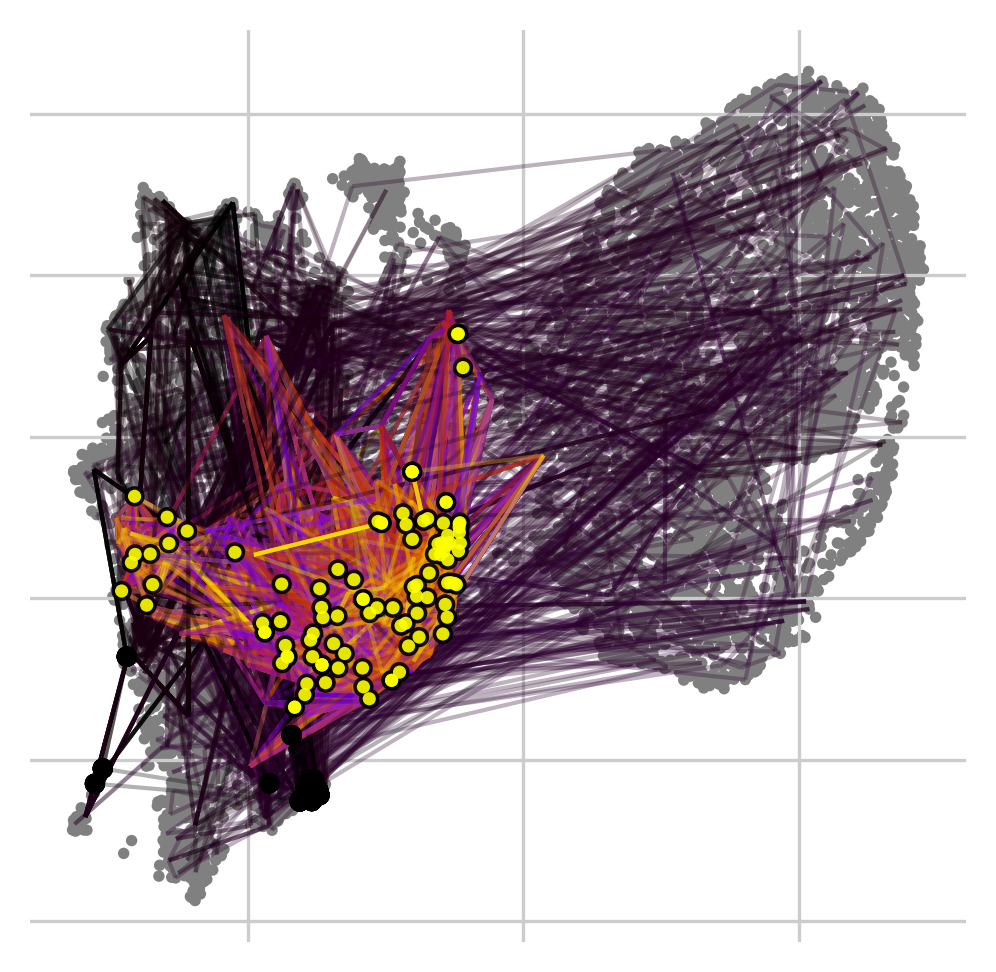

In [25]:
sc.set_figure_params(dpi=300)
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"Development_Day": 42},
    seed=0,
    dpi=150,
    size=30,
)


In [26]:
adata.obs['cluster'].value_counts()

cluster
ASS1+_SLC40A1+_SC    3979
RPS10+_RPS17+_SC     3544
FXYD3+_CKB+_SC        294
Name: count, dtype: int64

In [ ]:
sc.set_figure_params(dpi=300)
ax = tmk.plot_single_flow(
    cluster_key="cluster",
    time_key="Development_Day",
    min_flow=0.1,
    xticks_step_size=4,
    show=False,
    cluster = 'RPS10+_RPS17+_SC'
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Write anndata 

In [31]:
tmk.write_to_adata()

In [32]:
adata

AnnData object with n_obs × n_vars = 7817 × 19868
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster', 'Development_Week', 'Development_Day', 'proliferation', 'apoptosis'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells'
    uns: 'Age_colors', 'Age_group_colors', 'Donor_ID_colors', 'Library_Preparation_Protocol_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap', 'log1p', 'pca', 'cluster_colors', 'Sample_ID_colors', 'T_fwd_params'
    obsm: 'X_scVI', 

In [33]:
# Save anndata file 
output_path = 'FetalSC_data/Fetal_healthy_stem_cells_CellRank_experimental_time.h5ad'
adata.write(output_path)

In [ ]:
# upload anndata file
input = 'FetalSC_data/Fetal_healthy_stem_cells_CellRank_experimental_time.h5ad'
adata = sc.read_h5ad(input)